# Training with CVAE

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# cuda setup
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True}

# 15000 images, 7 label class, 120 latent dimention, 100*250 pixels, latent size = 1000

# hyper params
batch_size = 50
latent_size = 100 # latent dimension
h_latent_size = 2000 # latent space size
epochs = 15

# original 400*1000

height = 200 # of the image
width = 500
label_size = 6 # num of labels


In [ ]:
# implement multi label
def multi_hot(labels, class_size):
    multi_hot_labels = torch.zeros(len(labels), class_size)
    for i, label_list in enumerate(labels):
        for label in label_list:
            multi_hot_labels[i, label] = 1
    return multi_hot_labels.to(device)

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from PIL import Image
import ast

drive.mount('/content/drive')

# genre_map = {'70s': 0, '80s': 1, 'hiphop': 2, 'rock': 3, 'blues': 4, 'funk': 5, 'house': 6, 'soul': 7, 'pop': 8, 'electronic': 9,
#              'jazz': 10, 'world': 11, 'ambient': 12, 'rnb': 13, 'experimental': 14, 'alt/indie': 15, 'country/folk': 16, 'classical': 17
#              ,'symphony':17}


instruments_map = {'drum': 0, 'bass': 1, 'guitar': 2, 'key': 3, 'vocal': 4, 'synth': 5}

from collections import Counter

class SpectrogramDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.file = pd.read_csv(annotations_file)
        print("total file size: " + len(self.file))
        counter = Counter(self.file['Instrument'])
        print("instruments not in :" + counter['others'])
        self.file = self.file[[self.file['Instrument'] != 'others']]

        self.encoding_label = multi_hot([[instruments_map[i]] for i in self.file['Instrument']],label_size)

        # self.img_labels = [ast.literal_eval(self.file['Instrument'][i]) for i in range(len(self.file))]
        # self.encoding_label = multi_hot([[instruments_map[j] for j in i] for i in self.img_labels],label_size)

        # returns a list of list of genres
        # self.img_labels = [ast.literal_eval(self.file['Genre'][i]) for i in range(len(self.file))]
        # encode with multi_hot
        # self.encoding_label = multi_hot([[genre_map[j] for j in i] for i in self.img_labels],label_size)

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.file['Instrument'])

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{str(idx+1)}.png")
        label = self.encoding_label[idx]
        try:
            image = Image.open(img_name).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_name}: {e}")
            image = torch.zeros(3,height,width)
            return image,label
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((height, width)),  # Resize image to 1000x400
    transforms.ToTensor(),           # Convert image to tensor
])

dataset = SpectrogramDataset(annotations_file='/content/drive/My Drive/new_data.csv',
                        img_dir='/content/drive/My Drive/algophony_spectrograms/',transform = transform)

#### image dimension 3 x 400 x 1000 ####
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
5411


# Image Check
Making sure the images are intact

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
for batch in dataloader:
    images, labels = batch
    # print(images.shape)
    # print(labels.shape)
    img_tensor = images[0]
    # Convert tensor to PIL Image
    img_pil = torchvision.transforms.functional.to_pil_image(img_tensor)
    plt.imshow(img_pil)
    plt.axis('off')
    plt.show()

# Implementation

In [ ]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.latent_size = latent_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, h_latent_size)
        self.fc21 = nn.Linear(h_latent_size, latent_size)
        self.fc22 = nn.Linear(h_latent_size, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, h_latent_size)
        self.fc4 = nn.Linear(h_latent_size, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 3*width*height), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

    def generate(self, c, num_samples=1):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_size).to(c.device)
            x_generated = self.decode(z, c)
        return x_generated

# Training Step

In [ ]:
# create a CVAE model
model = CVAE(3*width*height, latent_size, label_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # reconstruction error
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 3*width*height), reduction='sum')
    MSE = F.mse_loss(recon_x, x.view(-1, 3*width*height), reduction='sum')
    # KL Divergence 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        # show progress
        # if batch_idx % 200 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(dataloader.dataset),
        #         100. * batch_idx / len(dataloader),
        #         loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))

# Train

In [ ]:
for epoch in range(epochs):
    train(epoch)
    # test(epoch)
    with torch.no_grad():
      c = torch.eye(label_size, label_size).cpu()
      sample = torch.randn(label_size, latent_size).to(device)
      sample = model.decode(sample, c).cpu()

Error opening image /content/drive/My Drive/algophony_spectrograms/2965.png: [Errno 2] No such file or directory: '/content/drive/My Drive/algophony_spectrograms/2965.png'
====> Epoch: 0 Average loss: 457784654025148.4375
Error opening image /content/drive/My Drive/algophony_spectrograms/2965.png: [Errno 2] No such file or directory: '/content/drive/My Drive/algophony_spectrograms/2965.png'


KeyboardInterrupt: 

torch.Size([1, 75000])


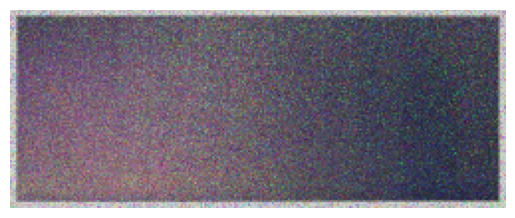

In [ ]:
num_samples = 1  # Number of samples to generate

# Generate Hiphop
label = multi_hot(torch.tensor([[2]]),label_size)

generated_samples = model.generate(label, num_samples=num_samples)

# You can now use or visualize the generated samples as needed
print(generated_samples.shape)

img_tensor = generated_samples.reshape(3, height, width)
img_pil = torchvision.transforms.functional.to_pil_image(img_tensor)
plt.imshow(img_pil)
plt.axis('off')
plt.show()